# Visualizing transport plans

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import ot
from scipy.io import loadmat 
from skimage.util import img_as_ubyte

from otimage import readers, imagerep, viewers
from otimage.utils import plot_maxproj, pixel_dist_3d

## Get frames and transport plan to test on 

### Load frame and corresponding MPs

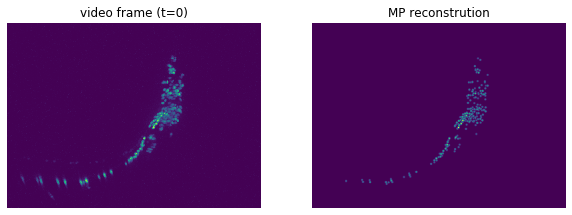

In [3]:
t_img = 0

# Load image from Zimmer data
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with readers.ZimmerReader(img_path) as reader:
    img_1 = reader.get_frame(t_img)
    img_shape = img_1.shape

# Load corresponding MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.mat'
mp_data = loadmat(mp_path)
cov = np.ascontiguousarray(mp_data['cov'])
pts_1 = np.ascontiguousarray(mp_data['means'][t_img, :, :])
wts_1_nn = np.ascontiguousarray(mp_data['weights'][t_img, :, 0])
wts_1 = wts_1_nn / np.sum(wts_1_nn)

# Reconstruct image using MPs
rec_1 = imagerep.reconstruct_image(pts_1, [cov], wts_1, img_shape)

plt.figure(figsize=(10,10))
    
plt.subplot(121)
plot_maxproj(img_1)
plt.title(f'video frame (t={t_img})')
plt.axis('off')

plt.subplot(122)
plot_maxproj(rec_1)
plt.title('MP reconstrution')
plt.axis('off');

### Apply linear transformation to frame

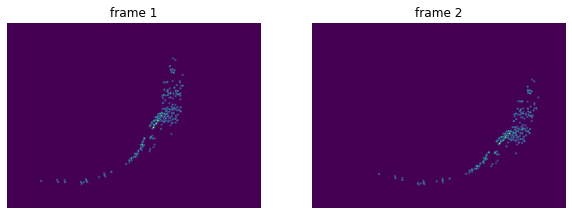

In [4]:
# Ground-truth transformation (rotation + translation)
theta = -np.pi / 16
beta = np.array([
    [np.cos(theta), -np.sin(theta), 0], 
    [np.sin(theta),  np.cos(theta), 0],
    [0,              0,             1]
])
alpha = np.array([100, 50, 0])

# Transform first image in MP space
pts_2 = (pts_1 @ beta.T + alpha).astype(int)
wts_2 = wts_1

# Reconstruct transformed image
rec_2 = imagerep.reconstruct_image(pts_2, [cov], wts_2, img_shape)

plt.figure(figsize=(10, 10))

plt.subplot(121)
plot_maxproj(rec_1)
plt.axis('off')
plt.title('frame 1')

plt.subplot(122)
plot_maxproj(rec_2)
plt.axis('off')
plt.title('frame 2');

### Compute OT between original image and transformed image

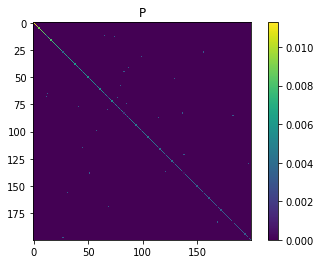

In [5]:
# Normalized distance matrix 
M_nn = ot.dist(pts_1, pts_2, metric='sqeuclidean')
M = M_nn / np.median(M_nn)

# Compute transport plan
P = ot.emd(wts_1, wts_2, M)

plt.imshow(P)
plt.colorbar()
plt.title('P');

## Test visualization approaches

### OT visualization approach 1: Use color-highlighted image

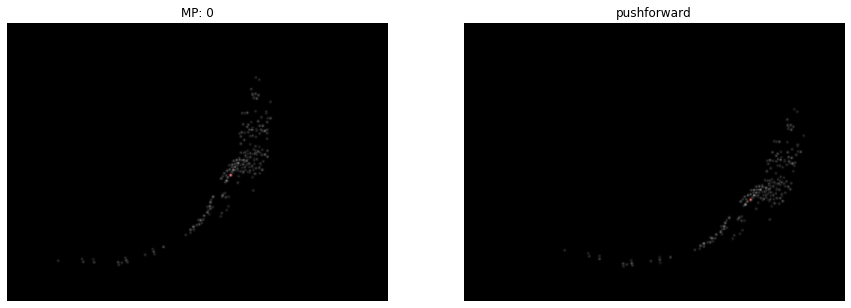

In [6]:
def highlight_img(img_hl, img_bg, wt):
    
    def _normalize(x):
        xmin = np.min(x)
        xmax = np.max(x)
        return (x - xmin) / (xmax - xmin)

    def _to_uint8(x):
        return (x * 255).astype('uint8')
    
    hl_norm = _normalize(img_hl)
    bg_norm = _normalize(img_bg)
    
    r_img = _to_uint8((1 - wt) * bg_norm + wt * hl_norm)
    b_img = _to_uint8((1 - wt) * bg_norm)
    g_img = _to_uint8((1 - wt) * bg_norm)
    
    return np.dstack([r_img, b_img, g_img])
   

idx = 0

pts_mp = pts_1[idx:idx+1, :]
wts_mp = wts_1[idx:idx+1]

p_row_nn = P[idx, :]
p_row = p_row_nn / np.sum(p_row_nn)
wts_pf = p_row[p_row > 0]
pts_pf = pts_2[p_row > 0]

img_mp = imagerep.reconstruct_image(pts_mp, [cov], wts_mp, img_shape) 
img_pf = imagerep.reconstruct_image(pts_pf, [cov], wts_pf, img_shape) 

plt_bg_1 = np.max(rec_1, 2).T
plt_bg_2 = np.max(rec_2, 2).T
plt_mp = np.max(img_mp, 2).T
plt_pf = np.max(img_pf, 2).T

rgb_mp = highlight_img(plt_mp, plt_bg_1, 0.5)
rgb_pf = highlight_img(plt_pf, plt_bg_2, 0.5)

plt.figure(figsize=(15, 15))

plt.subplot(121)
plt.imshow(rgb_mp, origin='lower')
plt.axis('off')
plt.title(f'MP: {idx}');

plt.subplot(122)
plt.imshow(rgb_pf, origin='lower')
plt.axis('off')
plt.title('pushforward');

### OT visualization approach 2: Use markers

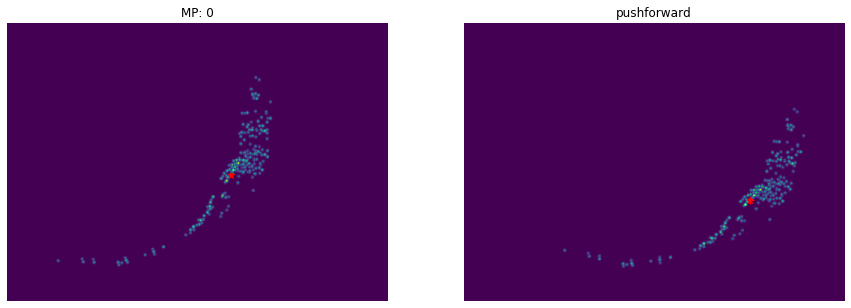

In [7]:
idx = 0

pt_mp = pts_1[idx]

wts_pf_nn = P[idx, :]
wts_pf = wts_pf_nn / np.sum(wts_pf_nn)
mean_pf = wts_pf.T @ pts_2
mode_pf = pts_2[np.argmax(wts_pf)]

plt.figure(figsize=(15, 15))

plt.subplot(121)
plot_maxproj(rec_1)
plt.plot(pt_mp[0], pt_mp[1], marker='*', color='red', markersize=7)
plt.axis('off')
plt.title(f'MP: {idx}')

plt.subplot(122)
plot_maxproj(rec_2)
plt.plot(mean_pf[0], mean_pf[1], marker='*', color='red', markersize=7)
plt.plot(mode_pf[0], mode_pf[1], marker='+', color='red', markersize=7)
plt.axis('off')
plt.title('pushforward');

### Widget for approach 2

In [10]:
viewer = viewers.PushforwardViewer(
    pts_1, pts_2, wts_1, wts_2, 
    cov, img_shape, P, figsize=(10, 10))

interactive(children=(IntSlider(value=0, continuous_update=False, description='MP:', max=200), Output()), _dom…